This notebook draws heavily from Francois Chollets Keras tutorial 
and Google LLC's cats versus dogs classifier tutorial.

The raw data is a reduced set of the Kaggle Dogs vs Cats dataset.


In [9]:
import numpy as np
import os

import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
%matplotlib inline

import matplotlib.image as mpimg

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [10]:
# set the path to the different directories
base_dir = './'                   # adapt if you store the images not in the same directory

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

# get the names of the training images
train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500


In [11]:
# here we add shearing, zooming, and horizontal flips to the images
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)


# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  
        target_size=(150, 150),  
        batch_size=20,
        class_mode='binary')


# Flow validation images in batches of 20 using val_datagen generator
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [13]:
# we set up a model for transfer learning
n_classes =2

# load the model 
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                    include_top=False)   # but not the dense layer at the output
#create our own output model
avg = layers.GlobalAveragePooling2D()(base_model.output)                  
output = layers.Dense(n_classes, activation="softmax")(avg)

# combine the two parts
model = Model(inputs=base_model.input, outputs=output)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, None, None, 32)       864       ['input_4[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, None, None, 32)       128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, None, None, 32)       0         ['block1_conv1_bn[0][0]'

In [14]:
# we will not train the base model
for layer in base_model.layers:
    layer.trainable = False                

    
# we train our dense output layer    
optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9)

model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

history = model.fit(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=1,
      validation_data=validation_generator,
      verbose=1)

2024-04-21 21:39:01.226815: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-04-21 21:39:01.382291: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-21 21:39:01.893111: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


  4/100 [>.............................] - ETA: 2s - loss: 3.0552 - accuracy: 0.6625  

2024-04-21 21:39:02.166179: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f8a424b3d00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-21 21:39:02.166215: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
I0000 00:00:1713706742.208365    7634 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


100/100 [==============================] - 11s 89ms/step - loss: 2.8679 - accuracy: 0.9175 - val_loss: 1.5727 - val_accuracy: 0.9570


### let's make predictions for 20 images from the predict dataset

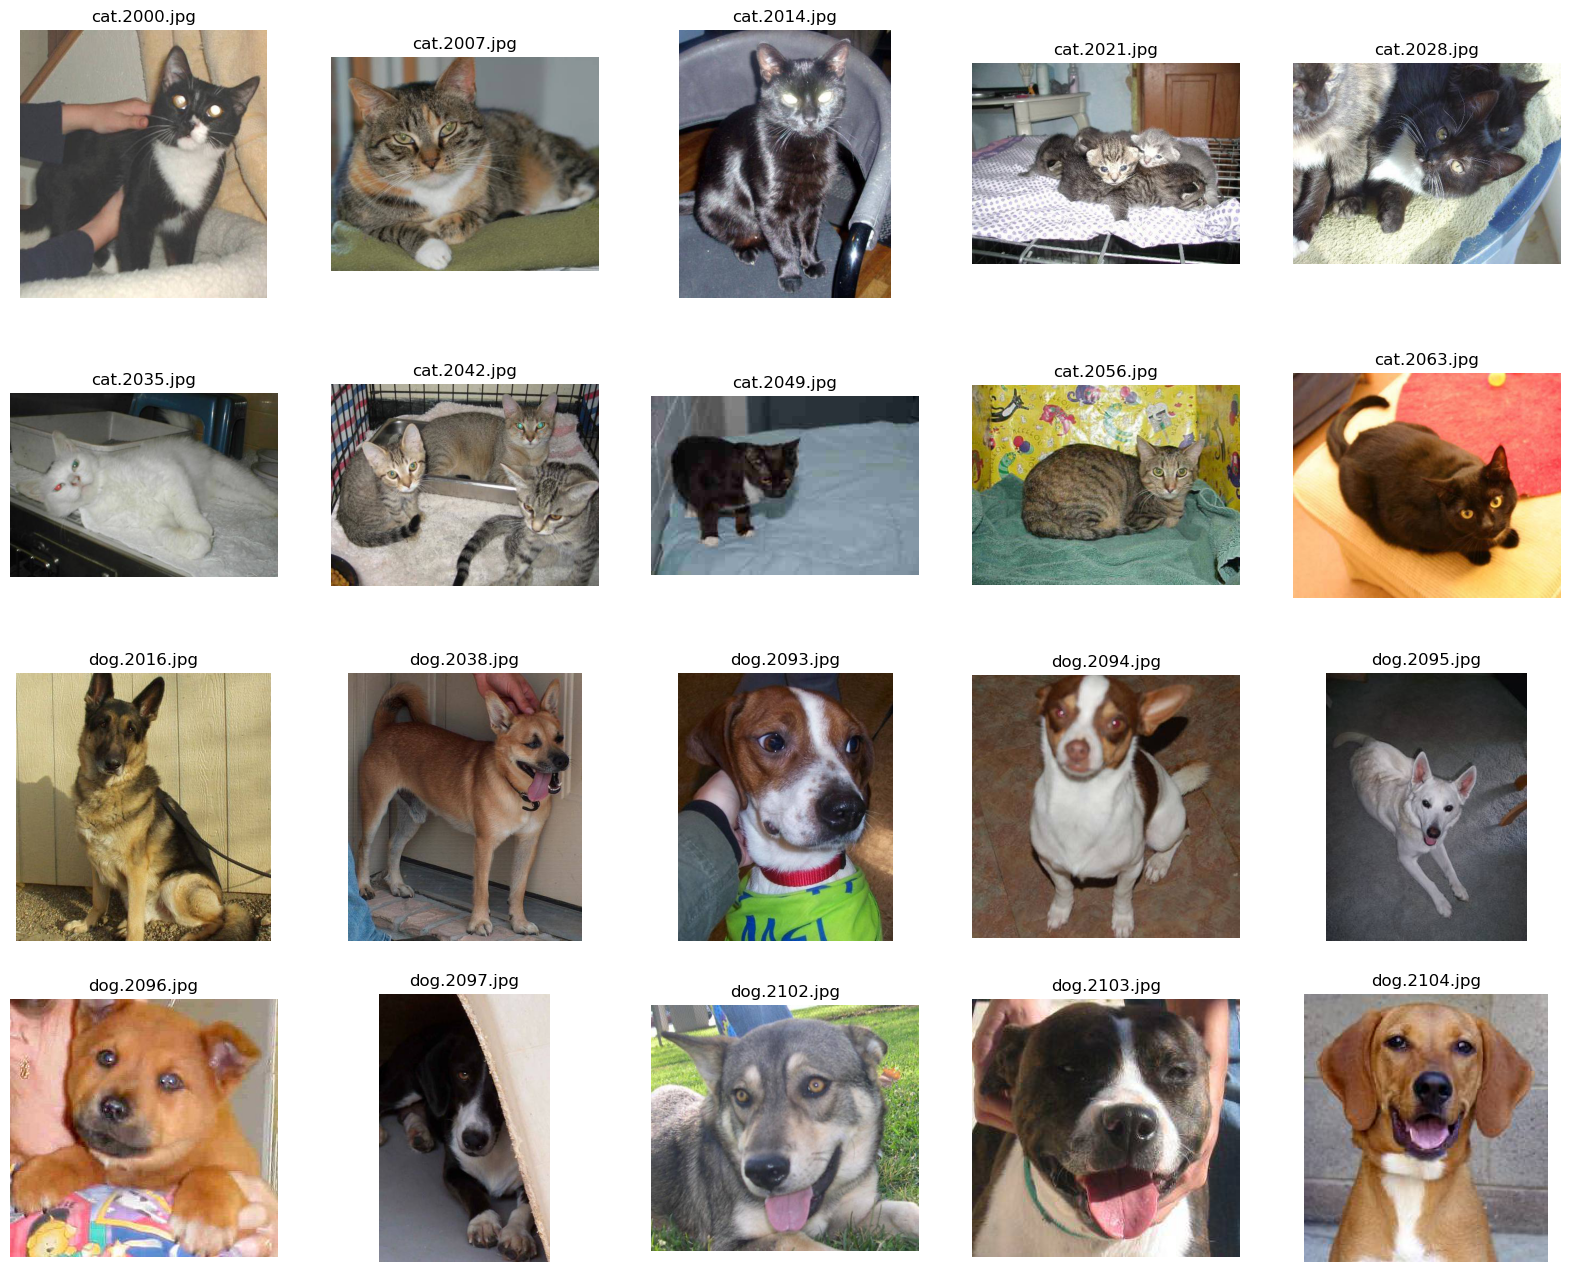

In [16]:
# first show the images
predict_dir = os.path.join(base_dir, 'predict')
predict_images_dir = os.path.join(predict_dir, 'images')
predict_fnames = sorted(os.listdir(predict_images_dir)) # sorted is important because flow_from_directory does so too

nrows = 4
ncols = 5

next_pix = [os.path.join(predict_images_dir, fname) 
              for fname in predict_fnames[0:ncols*nrows]]

plt.figure(figsize=(ncols * 4, nrows * 4))
for i, img_path in enumerate(next_pix):    
    plt.subplot(nrows, ncols, i+1)
    img = mpimg.imread(img_path)
    plt.title(predict_fnames[i])
    plt.imshow(img)
    plt.axis('off')
plt.show()


In [17]:
# second: make the predictions
image_generator = test_datagen.flow_from_directory(
        predict_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary',
        shuffle=False)               # important to keep the filenames and results aligned


y_pred = model.predict(image_generator)
print(y_pred)

Found 20 images belonging to 1 classes.
1/1 [==============================] - 0s 495ms/step
[[1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 1.2615062e-17]
 [1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00]
 [1.3053984e-26 1.0000000e+00]
 [0.0000000e+00 1.0000000e+00]
 [0.0000000e+00 1.0000000e+00]
 [0.0000000e+00 1.0000000e+00]
 [0.0000000e+00 1.0000000e+00]
 [0.0000000e+00 1.0000000e+00]
 [0.0000000e+00 1.0000000e+00]
 [0.0000000e+00 1.0000000e+00]
 [0.0000000e+00 1.0000000e+00]
 [0.0000000e+00 1.0000000e+00]]


In [18]:
# create labels
y_pred=np.round(y_pred[:,0])
print(y_pred)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
